In [40]:
import numpy as np
import pandas as pd
from pylab import rcParams
%pylab inline
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import ward_tree
from sklearn.metrics import silhouette_score
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import cityblock
from operator import itemgetter
from scipy.stats import itemfreq
from scipy.cluster.hierarchy import dendrogram, linkage
import scipy.spatial as sp


Populating the interactive namespace from numpy and matplotlib


In [20]:
rcParams['figure.figsize'] = 8,8

### Heatmap dati normalizzati e smooth (per confronto con dati clusterizzati)

/Users/francesco/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:2890: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  infer_datetime_format=infer_datetime_format)


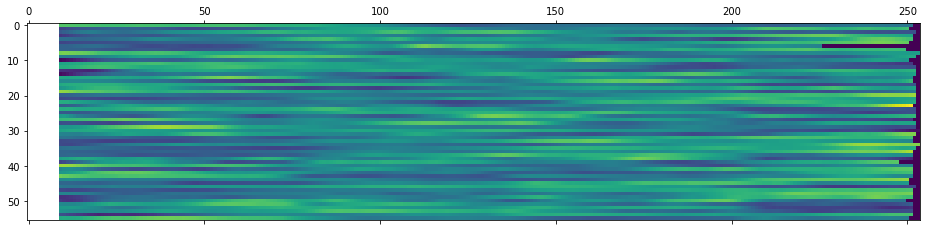

In [26]:
series = pd.Series.from_csv('dataset/ibm_daily_1962-2018.csv', sep='\t',header=0)
series = series["1962-01-02":"2017-12-29"]

groups = series.groupby(pd.Grouper(freq='A'))
years = []
yearly_series = []
yearly_list = []
for name, group in groups:
    years.append(name.year) # Lista contenente gli anni
    yearly_series.append(pd.Series(group)) # Lista contenente serie pandas per ogni anno
    yearly_list.append(list(group.values)) # Lista contenente liste per ogni anno

groups = series.groupby(pd.Grouper(freq='A'))
mm = pd.DataFrame()
for name, group in groups:
    norm_values = (group.values - mean(group.values)) / std(group.values)
    norm_series = pd.Series(norm_values) #trasformo in serie per calcolare la rolling mean
    shift_series = norm_series.rolling(window=10).mean()
    norm_array = np.array(shift_series)
    # Padding performed to have series of same length -- important only for plotting the matrix
    pad_values = np.pad(norm_array,(0,254-len(norm_array)),'constant',constant_values=-3)
    mm["%s" % (name.year)] = pad_values
matshow(mm.T, interpolation=None, aspect='auto')

In [27]:
# Serie Normalizzate + Smoothing
groups = series.groupby(pd.Grouper(freq='A'))
yearly_list_smooth = []
for name, group in groups:
    group_values = list(group.values)
    scaling_values = (group_values - mean(group_values))/std(group_values)
    scaling_series = pd.Series(scaling_values) #trasformo in serie per calcolare la rolling mean
    shift_series = scaling_series.rolling(window=10).mean()
    yearly_list_smooth.append(list(shift_series))

#rimozione missing values generati dallo smoothing con media mobile
yearly_series_smooth = []
for i in range(len(yearly_list_smooth)):
    yearly_series_smooth.append(pd.Series(yearly_list_smooth[i]))
    yearly_series_smooth[i] = pd.Series.dropna(yearly_series_smooth[i])

## Clustering con DTW

In [28]:
# Importo le matrici come dataframe
dd2_smooth_df = pd.read_csv("distance_matrices/dd2_smooth_dtw.csv", header = None)
dd2 = dd2_smooth_df.values.tolist()

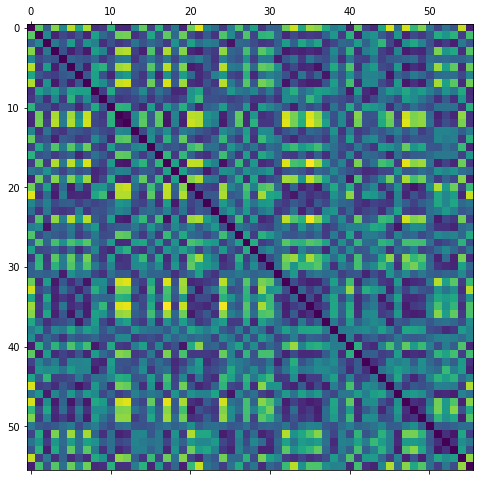

In [29]:
matshow(dd2, interpolation=None, aspect='auto')

### DBScan

#### Scelta eps

I parametri da impostare sono epsilon, che indica la distanza massima tra due punti per appartenere al medesimo cluster, e MinPts, che invece rappresenta il numero minimo di punti vicini (a distanza minore di epsilon) che ogni punto deve avere per non essere considerato noise.
Per la scelta del primo valore si è rappresentata in grafico la percentuale di noise (blu) rispetto al numero di cluster (arancione) per ogni valore di epsilon. Si è quindi scelto il valore epsilon = 40 che è un buon compromesso tra il numero dei cluster, in questo caso 6, e la percentuale di errore. Il parametro MinPts è invece stato lasciato a 2 dal momento che valori maggiori diminuivano fortemente il numero di cluster.

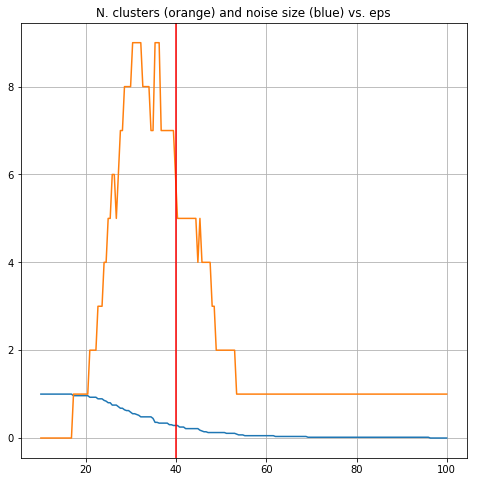

In [30]:
eps_list = linspace(10.0,100.0,num=200)
noise_list = array([])
n_clusters_list = array([])
for myeps in eps_list:
    db = DBSCAN(myeps, min_samples=2, metric='precomputed').fit(dd2)
    noise_list = append(noise_list, sum([ 1 if i==-1 else 0 for i in db.labels_]))
    n_clusters_list = append(n_clusters_list, len(set(db.labels_)) - (1 if -1 in db.labels_ else 0))
plot(eps_list, noise_list/56)
plot(eps_list, n_clusters_list)
pyplot.grid(True)
pyplot.title("N. clusters (orange) and noise size (blue) vs. eps")
plt.axvline(color = 'red', x = 40)

#### Clustering

In [31]:
from scipy.stats import itemfreq

eps = 40

db = DBSCAN(eps, min_samples=2, metric='precomputed').fit(dd2)

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)

print('Number of clusters found: %d' % n_clusters_)
print (itemfreq(db.labels_))

year_index= pd.Index(years) # Converto la lista degli anni in un pandas index array!!!
cluster_sets = [ (l_,year_index[db.labels_ == l_]) for l_ in set(db.labels_) ]
for pp in cluster_sets:
    print (pp[0], "\t--> ", list(pp[1]))

Number of clusters found: 6
[[-1 16]
 [ 0 15]
 [ 1  2]
 [ 2 16]
 [ 3  2]
 [ 4  3]
 [ 5  2]]
0 	-->  [1962, 1964, 1970, 1973, 1974, 1979, 1981, 1986, 1987, 2002, 2005, 2008, 2013, 2015, 2017]
1 	-->  [1963, 2003]
2 	-->  [1965, 1967, 1969, 1972, 1976, 1982, 1983, 1994, 1995, 1996, 1997, 1998, 2006, 2009, 2010, 2011]
3 	-->  [1966, 1993]
4 	-->  [1968, 1999, 2007]
5 	-->  [1980, 1984]
-1 	-->  [1971, 1975, 1977, 1978, 1985, 1988, 1989, 1990, 1991, 1992, 2000, 2001, 2004, 2012, 2014, 2016]


/Users/francesco/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  # This is added back by InteractiveShellApp.init_path()


#### Plot cluster 2

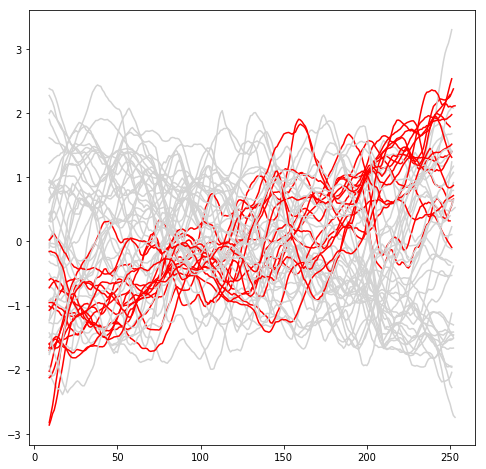

In [37]:
for i in range(len(db.labels_)):
    plot(yearly_series_smooth[i],'r-' if db.labels_[i]==2 else 'lightgray')

#### Confronto Heatmap pre/post clustering

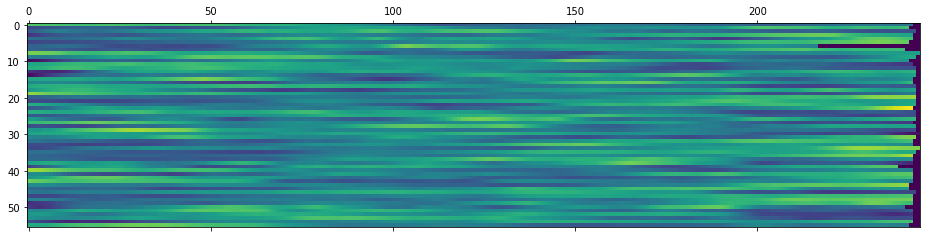

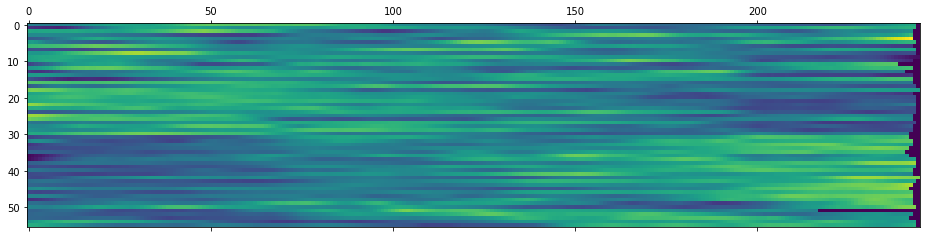

In [39]:
from operator import itemgetter
groups = series.groupby(pd.Grouper(freq='A'))
mm = pd.DataFrame()
for name, group in groups:
    scaling_values = (group.values - mean(group.values))/std(group.values)
    scaling_series = pd.Series(scaling_values)
    shift_values = scaling_series.rolling(window=10).mean()
    shift_values= shift_values.dropna()
    shift_values = np.array(shift_values)
    pad_values = np.pad(shift_values,(0,254-len(group.values)),'constant',constant_values=-3)
    mm["%s" % (name.year)] = pad_values
    
mm_sort=sorted(zip(array(mm.T),db.labels_),key=itemgetter(1))
mm_sort2=[el[0] for el in mm_sort]
matshow(mm.T, interpolation=None, aspect='auto')
matshow(mm_sort2, interpolation=None, aspect='auto')


### Hierarchical

L’algoritmo gerarchico utilizzato è di tipo agglomerativo, ossia parte dall’assunzione che inizialmente ogni cluster contenga un singolo punto. Ad ogni passo si uniscono tra loro i cluster più "vicini" fino ad ottenere un singolo cluster. In particolare il metodo di aggregazione utilizzato è complete linkage, il quale privilegia le dissomiglianze tra elementi, evidenziando la differenza tra i cluster piuttosto che l’omogeneità degli elementi di ogni gruppo.
Per la divisione in cluster si è analizzato il corrispondente dendrogramma e si è calcolata la silhouette score all’aumentare del numero di cluster. 

In [41]:
dd2_sq = sp.distance.squareform(dd2)
h_clustering = linkage(dd2_sq, metric = 'precomputed', method='complete')

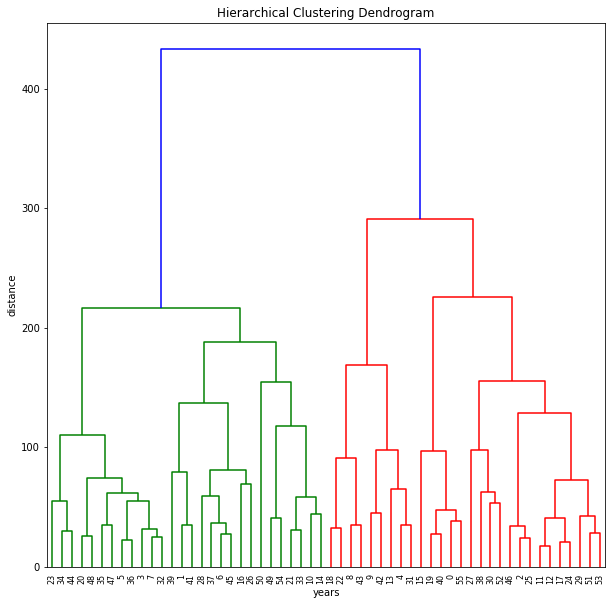

In [42]:
# calculate full dendrogram
plt.figure(figsize=(10, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('years')
plt.ylabel('distance')
dendrogram(
    h_clustering,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

#### Silhouette score

Il valore della silhouette, che varia nel range tra -1 e 1, è un indicatore di quanto un oggetto sia simile agli oggetti dello stesso cluster (coesione), rispetto a oggetti di cluster differenti (separazione).
Il valore utilizzato per il grafico è la media delle silhouette di tutti i dati al variare del numero di cluster.

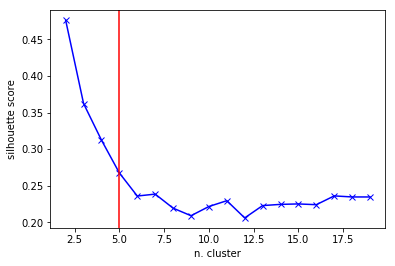

In [43]:
k = list(range(2,20))
silhouettes = []
for i in k:
    db = AgglomerativeClustering(n_clusters=i, linkage = 'complete', affinity='precomputed').fit(dd2)
    silhouettes.append(silhouette_score(dd2, db.labels_, metric="precomputed"))
# Plot silhouette scores
#plt.grid()
plt.plot(k, silhouettes, 'bx-')
plt.xlabel('n. cluster')
plt.ylabel('silhouette score')
plt.axvline(color = 'red', x = 5)
plt.show()

In [44]:
db = AgglomerativeClustering(n_clusters=5, linkage = 'complete', affinity='precomputed').fit(dd2)
sil = silhouette_score(dd2, db.labels_)
# Number of clusters in labels, ignoring noise if present.

n_clusters_ = len(set(db.labels_))

print('Number of clusters found: %d' % n_clusters_)
print (itemfreq(db.labels_))

year_index= pd.Index(years) # Converto la lista degli anni in un pandas index array!!!
cluster_sets = [ (l_,year_index[db.labels_ == l_]) for l_ in set(db.labels_) ]
for pp in cluster_sets:
    print (pp[0], "\t--> ", list(pp[1]))

Number of clusters found: 5
[[ 0 16]
 [ 1 14]
 [ 2  9]
 [ 3  5]
 [ 4 12]]
0 	-->  [1963, 1968, 1972, 1976, 1978, 1983, 1988, 1990, 1995, 1999, 2001, 2003, 2007, 2011, 2012, 2016]
1 	-->  [1964, 1973, 1974, 1979, 1986, 1987, 1989, 1991, 1992, 2000, 2008, 2013, 2014, 2015]
2 	-->  [1966, 1970, 1971, 1975, 1980, 1984, 1993, 2004, 2005]
3 	-->  [1962, 1977, 1981, 2002, 2017]
4 	-->  [1965, 1967, 1969, 1982, 1985, 1994, 1996, 1997, 1998, 2006, 2009, 2010]


/Users/francesco/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  


#### Plot cluster 4

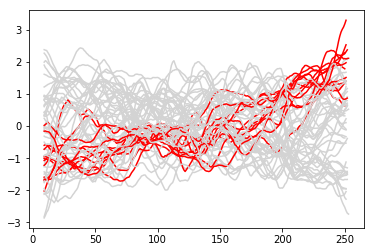

In [48]:
for i in range(len(db.labels_)):
    plot(yearly_series_smooth[i],'r-' if db.labels_[i]==4 else 'lightgray')

#### Confronto Heatmap pre/post clustering

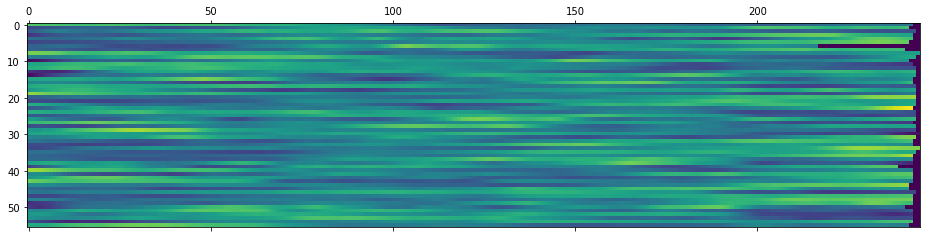

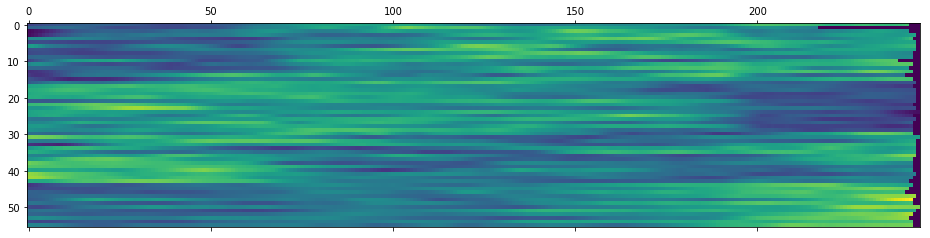

In [50]:
groups = series.groupby(pd.Grouper(freq='A'))
mm = pd.DataFrame()
for name, group in groups:
    scaling_values = (group.values - mean(group.values))/std(group.values)
    scaling_series = pd.Series(scaling_values)
    shift_values = scaling_series.rolling(window=10).mean()
    shift_values=shift_values.dropna()
    shift_values = np.array(shift_values)
    pad_values = np.pad(shift_values,(0,254-len(group.values)),'constant',constant_values=-3)
    mm["%s" % (name.year)] = pad_values
    
mm_sort=sorted(zip(array(mm.T),db.labels_),key=itemgetter(1))
mm_sort2=[el[0] for el in mm_sort]
matshow(mm.T, interpolation=None, aspect='auto')
matshow(mm_sort2, interpolation=None, aspect='auto')